In [1]:
def create_text_dataset():
    """Create a simple tokenized text dataset"""
    vocab = {
        '<pad>': 0, '<sos>': 1, '<eos>': 2,
        'the': 3, 'cat': 4, 'sat': 5, 'on': 6, 'mat': 7,
        'dog': 8, 'ran': 9, 'fast': 10, 'bird': 11, 'flew': 12, 'high': 13,
        'quick': 14, 'brown': 15, 'fox': 16, 'jumps': 17, 'over': 18, 'lazy': 19,
        'big': 20, 'small': 21, 'house': 22, 'tree': 23, 'water': 24, 'fire': 25
    }

    sentences = [
        "the cat sat on the mat",
        "the dog ran fast over the lazy cat",
        "the bird flew high over the big tree",
        "the quick brown fox jumps over the lazy dog",
        "the small cat sat on the big mat",
        "the fast dog ran over the small house"
    ]

    # Tokenize and pad
    tokenized = []
    for sentence in sentences:
        tokens = [vocab['<sos>']]
        tokens.extend([vocab.get(word, 0) for word in sentence.split()])
        tokens.append(vocab['<eos>'])
        tokenized.append(tokens)

    # Pad to same length
    max_len = max(len(seq) for seq in tokenized)
    padded = []
    for seq in tokenized:
        padded.append(seq + [0] * (max_len - len(seq)))

    return tokenized,torch.tensor(padded), vocab

#🚀 Custom Transformer Components

## Multi-Head Attention Variants

---

## 1. Symbols & Definitions

* **`d_model`** → embedding size of the model (here 256).

* **`num_heads`** → number of **query heads** (here 8).

* **`d_head`** → dimension of each query head:

  $$
  d_{head} = \frac{d_{model}}{num\_heads}
  $$

  → In your case: $256 / 8 = 32$.

* **`num_kv_heads`** → number of **key/value heads**.

  * Vanilla MHA: $num\_kv\_heads = num\_heads$.
  * GQA: $num\_kv\_heads < num\_heads$.
  * MQA: $num\_kv\_heads = 1$.

* **`d_kv`** → the **dimension of all K/V projections combined**.

  $$
  d_{kv} = d_{head} \times num\_kv\_heads
  $$

---

## 2. What each part means

* **`d_head` (32 in your case):**
  The “width” of a single attention head. Each query head looks at tokens through a subspace of size 32.

* **`num_kv_heads` (e.g. 1, 2, or 8):**
  How many *distinct* sets of K/V vectors are learned.

  * If 8 → every query head has its own K/V (MHA).
  * If 2 → groups of query heads share K/V (GQA).
  * If 1 → all queries share one K/V (MQA).

* **Multiplication `d_head × num_kv_heads`:**
  This gives the **total dimensionality of the projected K and V matrices**.

  * That’s why `w_k` and `w_v` have shapes `[d_kv, d_model]`.

---

## 3. Intuition of the multiplication

Think of it like this:

* Each KV head = a "view" into the sequence, of size `d_head`.
* If you have multiple KV heads, you stack them side by side.
* So the total space you need to project into is just:

  $$
  \text{total KV dimension} = d_{head} \times num\_kv\_heads
  $$

---

## 4. Concrete Examples (your config)

* **MHA (8 KV heads):**
  $d_{kv} = 32 \times 8 = 256$
  → K/V projection: `[256, 256]`

* **GQA (2 KV heads):**
  $d_{kv} = 32 \times 2 = 64$
  → K/V projection: `[64, 256]`

* **MQA (1 KV head):**
  $d_{kv} = 32 \times 1 = 32$
  → K/V projection: `[32, 256]`

---

✅ **Summary**:

* `d_head` → how wide each head is.
* `num_kv_heads` → how many *independent* K/V sets you maintain.
* `d_head × num_kv_heads` → total dimensionality of the K/V projection layer, i.e. how many numbers represent your keys/values per token.

---



In [2]:
def create_text_example():
    """Create a simple tokenized text example for testing"""
    vocab = {
        '<pad>': 0, '<sos>': 1, '<eos>': 2,
        'the': 3, 'cat': 4, 'sat': 5, 'on': 6, 'mat': 7,
        'dog': 8, 'ran': 9, 'fast': 10, 'bird': 11, 'flew': 12, 'high': 13,
        'quick': 14, 'brown': 15, 'fox': 16, 'jumps': 17, 'over': 18, 'lazy': 19,
        'big': 20, 'small': 21, 'house': 22, 'tree': 23, 'water': 24, 'fire': 25
    }

    sentences = [
        "the cat sat on the mat",
        "the dog ran fast over the lazy cat",
        "the bird flew high over the big tree",
        "the quick brown fox jumps over the lazy dog",
        "the small cat sat on the big mat",
        "the fast dog ran over the small house"
    ]

    # Convert to token IDs
    tokenized_sentences = []
    for sentence in sentences:
        tokens = [vocab['<sos>']]  # Start token
        tokens.extend([vocab.get(word, 0) for word in sentence.split()])
        tokens.append(vocab['<eos>'])  # End token
        tokenized_sentences.append(tokens)

    return tokenized_sentences, vocab


def pad_sequences(sequences, max_len=None, pad_value=0):
    """Pad sequences to the same length"""
    if max_len is None:
        max_len = max(len(seq) for seq in sequences)

    padded = []
    for seq in sequences:
        if len(seq) < max_len:
            padded.append(seq + [pad_value] * (max_len - len(seq)))
        else:
            padded.append(seq[:max_len])

    return padded

In [3]:
tokenized_sentences, vocab = create_text_example()
tokenized_sentences

[[1, 3, 4, 5, 6, 3, 7, 2],
 [1, 3, 8, 9, 10, 18, 3, 19, 4, 2],
 [1, 3, 11, 12, 13, 18, 3, 20, 23, 2],
 [1, 3, 14, 15, 16, 17, 18, 3, 19, 8, 2],
 [1, 3, 21, 4, 5, 6, 3, 20, 7, 2],
 [1, 3, 10, 8, 9, 18, 3, 21, 22, 2]]

In [4]:
test_padded_sequences = pad_sequences(tokenized_sentences)
test_padded_sequences

[[1, 3, 4, 5, 6, 3, 7, 2, 0, 0, 0],
 [1, 3, 8, 9, 10, 18, 3, 19, 4, 2, 0],
 [1, 3, 11, 12, 13, 18, 3, 20, 23, 2, 0],
 [1, 3, 14, 15, 16, 17, 18, 3, 19, 8, 2],
 [1, 3, 21, 4, 5, 6, 3, 20, 7, 2, 0],
 [1, 3, 10, 8, 9, 18, 3, 21, 22, 2, 0]]

In [5]:
import torch

test_input_ids = torch.tensor(test_padded_sequences)
test_input_ids.shape,test_input_ids

(torch.Size([6, 11]),
 tensor([[ 1,  3,  4,  5,  6,  3,  7,  2,  0,  0,  0],
         [ 1,  3,  8,  9, 10, 18,  3, 19,  4,  2,  0],
         [ 1,  3, 11, 12, 13, 18,  3, 20, 23,  2,  0],
         [ 1,  3, 14, 15, 16, 17, 18,  3, 19,  8,  2],
         [ 1,  3, 21,  4,  5,  6,  3, 20,  7,  2,  0],
         [ 1,  3, 10,  8,  9, 18,  3, 21, 22,  2,  0]]))

### Multi-Query Attention (MQA) - Memory efficient

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Multi-Query Attention (MQA) - Memory efficient
class MultiQueryAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.w_q = nn.Linear(d_model, d_model)  # Multiple query heads
        self.w_k = nn.Linear(d_model, self.d_k)  # Single key head
        self.w_v = nn.Linear(d_model, self.d_k)  # Single value head
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B, T, C = x.shape

        # Q: [B, T, d_model] -> [B, num_heads, T, d_k]
        q = self.w_q(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        # K, V: [B, T, C] -> [B, 1, T, d_k] -> broadcast to [B, num_heads, T, d_k]
        k = self.w_k(x).view(B, T, 1, self.d_k).transpose(1, 2).expand(-1, self.num_heads, -1, -1)
        v = self.w_v(x).view(B, T, 1, self.d_k).transpose(1, 2).expand(-1, self.num_heads, -1, -1)

        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores.masked_fill_(mask == 0, -1e9)

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        out = torch.matmul(attn_weights, v)  # [B, num_heads, T, d_k]
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        return self.w_o(out)



| Method  | num\_heads | num\_kv\_heads | Total Params |
| ------- | ---------- | -------------- | ------------ |
| **MHA** | 8          | 8              | **262,400**  |
| **GQA** | 8          | 2              | **164,480**  |
| **MQA** | 8          | 1              | **148,032**  |

**MHA (full)**: Heaviest — every query head has its own KV projections.

**GQA (middle ground)**: Balance — queries are many, but KVs are grouped. (LLaMA-2/3 style)

**MQA (extreme case)**: Lightest — one shared KV for all query heads (PaLM, Gemini, Whisper use this).

    w_k or w_v [d_kv, d_model] = [32, 256]

Because you’re using MQA with num_heads=8 but only num_kv_heads=1, the keys/values don’t need a full 256-d projection. Instead:

    Each KV head gets dimension: d_model/num_heads = 265/8 = 32
    With 1 KV heads (num_kv_heads=1) = 32 * 2 = 32



In [7]:

def test_multi_query_attention():
    """Test the MultiQueryAttention module with text examples"""
    print("Testing Multi-Query Attention with Text Examples")
    print("=" * 60)

    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Create text examples
    tokenized_sentences, vocab = create_text_example()
    print("Original sentences:")
    sentences = ["the cat sat on the mat", "the dog ran fast", "the bird flew high"]
    for i, sentence in enumerate(sentences):
        print(f"  {i+1}. '{sentence}' -> {tokenized_sentences[i]}")

    # Pad sequences
    max_seq_len = 8
    padded_sequences = pad_sequences(tokenized_sentences, max_seq_len)
    input_ids = torch.tensor(padded_sequences)

    print(f"\nPadded input tensor shape: {input_ids.shape}")
    print("Padded sequences:")
    for i, seq in enumerate(padded_sequences):
        print(f"  Sequence {i+1}: {seq}")

    # Model configuration
    d_model = 256
    num_heads = 8
    vocab_size = len(vocab)
    batch_size, seq_length = input_ids.shape

    print(f"\nModel Configuration:")
    print(f"  d_model: {d_model}")
    print(f"  num_heads: {num_heads}")
    print(f"  vocab_size: {vocab_size}")
    print(f"  sequence_length: {seq_length}")

    # Create embedding layer and MQA
    embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
    mqa = MultiQueryAttention(d_model, num_heads, dropout=0.1)

    # Convert tokens to embeddings
    x = embedding(input_ids)  # [batch_size, seq_length, d_model]
    print(f"\nEmbedding output shape [batch_size, seq_length, d_model]: {x.shape}")

    # Create attention mask (ignore padding tokens)
    attention_mask = (input_ids != 0).float()
    causal_mask = attention_mask.unsqueeze(1).unsqueeze(2)
    causal_mask = causal_mask.expand(-1, num_heads, seq_length, -1)

    print(f"\nAttention mask shape [batch_size, seq_length]: {attention_mask.shape}")
    print(f"\nAttention mask shape [batch_size, seq_length, seq_length,seq_length]: {causal_mask.shape}")
    print("Attention mask for first sequence (first head):")
    print(causal_mask[0, 0].int())

    # Forward pass through GQA
    print("\n" + "-" * 40)
    print("Running MQA Forward Pass...")
    mqa.eval()
    with torch.no_grad():
        output = mqa(x, mask=causal_mask)

    print(f"\nGQA output shape: {output.shape}")
    print("Output statistics:")
    print(f"  Mean: {output.mean():.4f}")
    print(f"  Std: {output.std():.4f}")
    print(f"  Min: {output.min():.4f}")
    print(f"  Max: {output.max():.4f}")

    # Show parameter breakdown
    print(f"\nModel Parameter Analysis:")
    total_params = sum(p.numel() for p in mqa.parameters())
    print(f"  Total GQA parameters: {total_params:,}")

    print("\n  Parameter breakdown:")
    for name, param in mqa.named_parameters():
        print(f"    {name}: {param.shape} -> {param.numel():,} parameters")

    print("\nTest completed successfully!")

In [8]:
test_multi_query_attention()

Testing Multi-Query Attention with Text Examples
Original sentences:
  1. 'the cat sat on the mat' -> [1, 3, 4, 5, 6, 3, 7, 2]
  2. 'the dog ran fast' -> [1, 3, 8, 9, 10, 18, 3, 19, 4, 2]
  3. 'the bird flew high' -> [1, 3, 11, 12, 13, 18, 3, 20, 23, 2]

Padded input tensor shape: torch.Size([6, 8])
Padded sequences:
  Sequence 1: [1, 3, 4, 5, 6, 3, 7, 2]
  Sequence 2: [1, 3, 8, 9, 10, 18, 3, 19]
  Sequence 3: [1, 3, 11, 12, 13, 18, 3, 20]
  Sequence 4: [1, 3, 14, 15, 16, 17, 18, 3]
  Sequence 5: [1, 3, 21, 4, 5, 6, 3, 20]
  Sequence 6: [1, 3, 10, 8, 9, 18, 3, 21]

Model Configuration:
  d_model: 256
  num_heads: 8
  vocab_size: 26
  sequence_length: 8

Embedding output shape [batch_size, seq_length, d_model]: torch.Size([6, 8, 256])

Attention mask shape [batch_size, seq_length]: torch.Size([6, 8])

Attention mask shape [batch_size, seq_length, seq_length,seq_length]: torch.Size([6, 8, 8, 8])
Attention mask for first sequence (first head):
tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1,

### Grouped Query Attention (GQA) - Balanced approach

In [9]:
# Grouped Query Attention (GQA) - Balanced approach
class GroupedQueryAttention(nn.Module):
    def __init__(self, d_model, num_heads, num_kv_heads, dropout=0.1):
        super().__init__()
        assert num_heads % num_kv_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.num_kv_heads = num_kv_heads
        self.d_k = d_model // num_heads
        self.groups = num_heads // num_kv_heads

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, num_kv_heads * self.d_k)
        self.w_v = nn.Linear(d_model, num_kv_heads * self.d_k)
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B, T, C = x.shape

        # Q: [B, T, d_model] -> [B, num_heads, T, d_k]
        q = self.w_q(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        # K, V: [B, T, C] -> [B, num_kv_heads, T, d_k]
        k = self.w_k(x).view(B, T, self.num_kv_heads, self.d_k).transpose(1, 2)
        v = self.w_v(x).view(B, T, self.num_kv_heads, self.d_k).transpose(1, 2)

        # Repeat K, V for each group
        k = k.repeat_interleave(self.groups, dim=1)  # [B, num_heads, T, d_k]
        v = v.repeat_interleave(self.groups, dim=1)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores.masked_fill_(mask == 0, -1e9)

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        out = torch.matmul(attn_weights, v)
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        return self.w_o(out)



    w_q [d_model, d_model] = [256, 256]
This projects the input embedding of size 256 into queries of the same size (since you have 8 query heads).

    w_k or w_v [d_kv, d_model] = [64, 256]

Because you’re using GQA with num_heads=8 but only num_kv_heads=2, the keys/values don’t need a full 256-d projection. Instead:

    Each KV head gets dimension: d_model/num_heads = 265/8 = 32
    With 2 KV heads (num_kv_heads=2) = 32 * 2 = 64

After attention scores are applied, you project the concatenated heads back to the model dimension.

    w_o [d_model, d_model] = [256, 256]

**Why queries are bigger (256-d) but keys/values are smaller (64-d)?**

  → Because in Grouped-Query Attention (GQA), you have more query heads (8) than key/value heads (2). This reduces memory/computation since multiple query heads can share the same smaller key/value projections.

In [10]:
def test_group_query_attention():
    """Test the GroupQueryAttention module with text examples"""
    print("Testing Group-Query Attention with Text Examples")
    print("=" * 60)

    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Create text examples
    tokenized_sentences, vocab = create_text_example()
    print("Original sentences:")
    sentences = ["the cat sat on the mat", "the dog ran fast", "the bird flew high"]
    for i, sentence in enumerate(sentences):
        print(f"  {i+1}. '{sentence}' -> {tokenized_sentences[i]}")

    # Pad sequences
    max_seq_len = 8
    padded_sequences = pad_sequences(tokenized_sentences, max_seq_len)
    input_ids = torch.tensor(padded_sequences)

    print(f"\nPadded input tensor shape: {input_ids.shape}")
    print("Padded sequences:")
    for i, seq in enumerate(padded_sequences):
        print(f"  Sequence {i+1}: {seq}")

    # Model configuration
    d_model = 256
    num_heads = 8
    num_kv_heads = 2   # Set for GQA (for example, 2 kv heads for 8 query heads)
    vocab_size = len(vocab)
    batch_size, seq_length = input_ids.shape

    print(f"\nModel Configuration:")
    print(f"  d_model: {d_model}")
    print(f"  num_heads: {num_heads}")
    print(f"  num_kv_heads: {num_kv_heads}")
    print(f"  vocab_size: {vocab_size}")
    print(f"  sequence_length: {seq_length}")

    # Create embedding layer and GroupedQueryAttention
    embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
    gqa = GroupedQueryAttention(d_model, num_heads, num_kv_heads, dropout=0.1)

    # Convert tokens to embeddings
    x = embedding(input_ids)  # [batch_size, seq_length, d_model]
    print(f"\nEmbedding output shape: {x.shape}")

    # Create attention mask (ignore padding tokens)
    attention_mask = (input_ids != 0).float()
    causal_mask = attention_mask.unsqueeze(1).unsqueeze(2)
    causal_mask = causal_mask.expand(-1, num_heads, seq_length, -1)

    print(f"\nAttention mask shape [batch_size, seq_length]: {attention_mask.shape}")
    print(f"\nAttention mask shape [batch_size, seq_length, seq_length,seq_length]: {causal_mask.shape}")
    print("Attention mask for first sequence (first head):")
    print(causal_mask[0, 0].int())

    # Forward pass through GQA
    print("\n" + "-" * 40)
    print("Running GQA Forward Pass...")
    gqa.eval()
    with torch.no_grad():
        output = gqa(x, mask=causal_mask)

    print(f"\nGQA output shape: {output.shape}")
    print("Output statistics:")
    print(f"  Mean: {output.mean():.4f}")
    print(f"  Std: {output.std():.4f}")
    print(f"  Min: {output.min():.4f}")
    print(f"  Max: {output.max():.4f}")

    # Show parameter breakdown
    print(f"\nModel Parameter Analysis:")
    total_params = sum(p.numel() for p in gqa.parameters())
    print(f"  Total GQA parameters: {total_params:,}")

    print("\n  Parameter breakdown:")
    for name, param in gqa.named_parameters():
        print(f"    {name}: {param.shape} -> {param.numel():,} parameters")

    print("\nTest completed successfully!")

In [11]:
test_group_query_attention()

Testing Group-Query Attention with Text Examples
Original sentences:
  1. 'the cat sat on the mat' -> [1, 3, 4, 5, 6, 3, 7, 2]
  2. 'the dog ran fast' -> [1, 3, 8, 9, 10, 18, 3, 19, 4, 2]
  3. 'the bird flew high' -> [1, 3, 11, 12, 13, 18, 3, 20, 23, 2]

Padded input tensor shape: torch.Size([6, 8])
Padded sequences:
  Sequence 1: [1, 3, 4, 5, 6, 3, 7, 2]
  Sequence 2: [1, 3, 8, 9, 10, 18, 3, 19]
  Sequence 3: [1, 3, 11, 12, 13, 18, 3, 20]
  Sequence 4: [1, 3, 14, 15, 16, 17, 18, 3]
  Sequence 5: [1, 3, 21, 4, 5, 6, 3, 20]
  Sequence 6: [1, 3, 10, 8, 9, 18, 3, 21]

Model Configuration:
  d_model: 256
  num_heads: 8
  num_kv_heads: 2
  vocab_size: 26
  sequence_length: 8

Embedding output shape: torch.Size([6, 8, 256])

Attention mask shape [batch_size, seq_length]: torch.Size([6, 8])

Attention mask shape [batch_size, seq_length, seq_length,seq_length]: torch.Size([6, 8, 8, 8])
Attention mask for first sequence (first head):
tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 

### FlexAttention - PyTorch 2.5+ with custom score modifiers

In [12]:
# FlexAttention - PyTorch 2.5+ with custom score modifiers

import torch

def causal_mask(score, batch, head, q_idx, kv_idx):
    return torch.where(q_idx >= kv_idx, score, float('-inf'))

def sliding_window_mask(window_size):
    def mask_fn(score, batch, head, q_idx, kv_idx):
        return torch.where(
            torch.abs(q_idx - kv_idx) <= window_size,
            score, float('-inf')
        )
    return mask_fn


def attention_bias_mask(bias_value=0.1):
    """Add a small bias to attention scores"""
    def mask_fn(score, batch, head, q_idx, kv_idx):
        return score + bias_value
    return mask_fn


def position_dependent_mask(decay_factor=0.1):
    """Apply position-dependent decay to attention scores"""
    def mask_fn(score, batch, head, q_idx, kv_idx):
        distance = torch.abs(q_idx - kv_idx).float()
        decay = torch.exp(-decay_factor * distance)
        return score * decay
    return mask_fn


class FlexAttentionWrapper(nn.Module):
    """Wrapper for FlexAttention with different score modifiers"""
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, score_mod=None):
        B, T, C = x.shape

        # Generate Q, K, V
        q = self.w_q(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        k = self.w_k(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        v = self.w_v(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)

        # Use FlexAttention if available, otherwise fallback to standard attention
        try:
            from torch.nn.attention.flex_attention import flex_attention
            # FlexAttention expects [B, H, T, D] format
            if score_mod is not None:
                out = flex_attention(q, k, v, score_mod=score_mod)
            else:
                out = flex_attention(q, k, v)
        except ImportError:
            print("FlexAttention not available, using standard attention fallback")
            # Fallback to standard attention
            scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)

            # Apply score modifier manually if provided
            if score_mod is not None:
                print("Warning: score_mod ignored in fallback mode")

            attn_weights = F.softmax(scores, dim=-1)
            attn_weights = self.dropout(attn_weights)
            out = torch.matmul(attn_weights, v)

        # Reshape output
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        return self.w_o(out)

# Usage with FlexAttention (PyTorch 2.5+)
# from torch.nn.attention.flex_attention import flex_attention
# output = flex_attention(query, key, value, score_mod=causal_mask)

In [13]:
def test_flex_attention():
    """Test the FlexAttention wrapper with different score modifiers"""
    print("Testing FlexAttention with Text Examples")
    print("=" * 60)

    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Create text examples
    tokenized_sentences, vocab = create_text_example()
    print("Original sentences:")
    sentences = [
        "the cat sat on the mat",
        "the dog ran fast",
        "the bird flew high",
        "the quick brown fox jumps"
    ]
    # for i, sentence in enumerate(sentences):
    #     print(f"  {i+1}. '{sentence}' -> {tokenized_sentences[i]}")

    # Pad sequences
    max_seq_len = 10
    padded_sequences = pad_sequences(tokenized_sentences, max_seq_len)
    input_ids = torch.tensor(padded_sequences)

    print(f"\nPadded input tensor shape: {input_ids.shape}")
    print("Padded sequences:")
    for i, seq in enumerate(padded_sequences):
        print(f"  Sequence {i+1}: {seq}")

    # Model configuration
    d_model = 256
    num_heads = 8
    vocab_size = len(vocab)
    batch_size, seq_length = input_ids.shape

    print(f"\nModel Configuration:")
    print(f"  d_model: {d_model}")
    print(f"  num_heads: {num_heads}")
    print(f"  vocab_size: {vocab_size}")
    print(f"  sequence_length: {seq_length}")

    # Create embedding layer and FlexAttention
    embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
    flex_attn = FlexAttentionWrapper(d_model, num_heads, dropout=0.1)

    # Convert tokens to embeddings
    x = embedding(input_ids)  # [batch_size, seq_length, d_model]
    print(f"\nEmbedding output shape: {x.shape}")

    # Test different score modifiers
    score_modifiers = {
        "No modifier": None,
        "Causal mask": causal_mask,
        "Sliding window (size=3)": sliding_window_mask(3),
        "Sliding window (size=5)": sliding_window_mask(5),
        "Attention bias": attention_bias_mask(0.1),
        "Position decay": position_dependent_mask(0.2)
    }

    print("\n" + "-" * 50)
    print("Testing Different Score Modifiers")
    print("-" * 50)

    flex_attn.eval()
    results = {}

    for name, score_mod in score_modifiers.items():
        print(f"\nTesting: {name}")
        print("-" * 30)

        with torch.no_grad():
            try:
                output = flex_attn(x, score_mod=score_mod)
                results[name] = output

                print(f"  Output shape: {output.shape}")
                print(f"  Output statistics:")
                print(f"    Mean: {output.mean():.4f}")
                print(f"    Std: {output.std():.4f}")
                print(f"    Min: {output.min():.4f}")
                print(f"    Max: {output.max():.4f}")

            except Exception as e:
                print(f"  Error: {e}")
                results[name] = None

    # Compare different score modifiers
    print("\n" + "-" * 50)
    print("Comparing Score Modifiers")
    print("-" * 50)

    base_output = results.get("No modifier")
    if base_output is not None:
        for name, output in results.items():
            if output is not None and name != "No modifier":
                diff = torch.abs(output - base_output).mean()
                print(f"{name:25} vs No modifier: Avg diff = {diff:.6f}")

    # Parameter analysis
    print(f"\nModel Parameter Analysis:")
    total_params = sum(p.numel() for p in flex_attn.parameters())
    print(f"  Total FlexAttention parameters: {total_params:,}")

    print("\n  Parameter breakdown:")
    for name, param in flex_attn.named_parameters():
        print(f"    {name}: {param.shape} -> {param.numel():,} parameters")

    print("\n" + "=" * 60)
    print("FlexAttention test completed!")

    return flex_attn, results, input_ids, vocab


def test_score_modifier_behaviors():
    """Test specific behaviors of different score modifiers"""
    print("\n" + "=" * 60)
    print("Testing Score Modifier Behaviors")
    print("=" * 60)

    # Create simple test data
    seq_len = 6
    batch_size = 1

    # Simulate score matrix for visualization
    print("\nScore Modifier Behavior Analysis:")
    print("(Simulating attention patterns)")

    # Test causal mask
    print("\n1. Causal Mask:")
    print("   Only allows attention to previous positions")
    for q_idx in range(seq_len):
        mask_pattern = []
        for kv_idx in range(seq_len):
            if q_idx >= kv_idx:
                mask_pattern.append("✓")
            else:
                mask_pattern.append("✗")
        print(f"   Position {q_idx}: {' '.join(mask_pattern)}")

    # Test sliding window
    window_size = 2
    print(f"\n2. Sliding Window (size={window_size}):")
    print("   Only allows attention within window")
    for q_idx in range(seq_len):
        mask_pattern = []
        for kv_idx in range(seq_len):
            if abs(q_idx - kv_idx) <= window_size:
                mask_pattern.append("✓")
            else:
                mask_pattern.append("✗")
        print(f"   Position {q_idx}: {' '.join(mask_pattern)}")

    print("\n3. Position Decay:")
    print("   Attention strength decreases with distance")
    decay_factor = 0.3
    for q_idx in [0, 2, 4]:
        decay_values = []
        for kv_idx in range(seq_len):
            distance = abs(q_idx - kv_idx)
            decay = math.exp(-decay_factor * distance)
            decay_values.append(f"{decay:.2f}")
        print(f"   From pos {q_idx}: {' '.join(decay_values)}")


In [14]:
def demonstrate_flex_attention_features():
    """Demonstrate key features of FlexAttention"""
    print("\n" + "=" * 60)
    print("FlexAttention Key Features")
    print("=" * 60)

    features = [
        "✓ Custom score modification functions",
        "✓ Efficient computation with PyTorch 2.5+",
        "✓ Support for causal masking",
        "✓ Sliding window attention patterns",
        "✓ Position-dependent attention weighting",
        "✓ Flexible attention bias injection",
        "✓ Memory-efficient implementation",
        "✓ Backward compatibility fallback"
    ]

    print("\nSupported Features:")
    for feature in features:
        print(f"  {feature}")

    print("\nUse Cases:")
    use_cases = [
        "• Language modeling with causal attention",
        "• Local attention for long sequences",
        "• Position-biased attention mechanisms",
        "• Custom attention patterns for specific tasks",
        "• Efficient transformer variants"
    ]

    for use_case in use_cases:
        print(f"  {use_case}")


In [15]:
# Run main test
flex_model, results, input_ids, vocab = test_flex_attention()



Testing FlexAttention with Text Examples
Original sentences:

Padded input tensor shape: torch.Size([6, 10])
Padded sequences:
  Sequence 1: [1, 3, 4, 5, 6, 3, 7, 2, 0, 0]
  Sequence 2: [1, 3, 8, 9, 10, 18, 3, 19, 4, 2]
  Sequence 3: [1, 3, 11, 12, 13, 18, 3, 20, 23, 2]
  Sequence 4: [1, 3, 14, 15, 16, 17, 18, 3, 19, 8]
  Sequence 5: [1, 3, 21, 4, 5, 6, 3, 20, 7, 2]
  Sequence 6: [1, 3, 10, 8, 9, 18, 3, 21, 22, 2]

Model Configuration:
  d_model: 256
  num_heads: 8
  vocab_size: 26
  sequence_length: 10

Embedding output shape: torch.Size([6, 10, 256])

--------------------------------------------------
Testing Different Score Modifiers
--------------------------------------------------

Testing: No modifier
------------------------------
  Output shape: torch.Size([6, 10, 256])
  Output statistics:
    Mean: 0.0164
    Std: 0.1134
    Min: -0.3531
    Max: 0.4660

Testing: Causal mask
------------------------------
  Output shape: torch.Size([6, 10, 256])
  Output statistics:
    Mean

In [16]:
results.keys(),input_ids.shape


(dict_keys(['No modifier', 'Causal mask', 'Sliding window (size=3)', 'Sliding window (size=5)', 'Attention bias', 'Position decay']),
 torch.Size([6, 10]))

In [17]:
flex_model

FlexAttentionWrapper(
  (w_q): Linear(in_features=256, out_features=256, bias=True)
  (w_k): Linear(in_features=256, out_features=256, bias=True)
  (w_v): Linear(in_features=256, out_features=256, bias=True)
  (w_o): Linear(in_features=256, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [18]:
# Run additional analyses
test_score_modifier_behaviors()



Testing Score Modifier Behaviors

Score Modifier Behavior Analysis:
(Simulating attention patterns)

1. Causal Mask:
   Only allows attention to previous positions
   Position 0: ✓ ✗ ✗ ✗ ✗ ✗
   Position 1: ✓ ✓ ✗ ✗ ✗ ✗
   Position 2: ✓ ✓ ✓ ✗ ✗ ✗
   Position 3: ✓ ✓ ✓ ✓ ✗ ✗
   Position 4: ✓ ✓ ✓ ✓ ✓ ✗
   Position 5: ✓ ✓ ✓ ✓ ✓ ✓

2. Sliding Window (size=2):
   Only allows attention within window
   Position 0: ✓ ✓ ✓ ✗ ✗ ✗
   Position 1: ✓ ✓ ✓ ✓ ✗ ✗
   Position 2: ✓ ✓ ✓ ✓ ✓ ✗
   Position 3: ✗ ✓ ✓ ✓ ✓ ✓
   Position 4: ✗ ✗ ✓ ✓ ✓ ✓
   Position 5: ✗ ✗ ✗ ✓ ✓ ✓

3. Position Decay:
   Attention strength decreases with distance
   From pos 0: 1.00 0.74 0.55 0.41 0.30 0.22
   From pos 2: 0.55 0.74 1.00 0.74 0.55 0.41
   From pos 4: 0.30 0.41 0.55 0.74 1.00 0.74


In [19]:
demonstrate_flex_attention_features()


FlexAttention Key Features

Supported Features:
  ✓ Custom score modification functions
  ✓ Efficient computation with PyTorch 2.5+
  ✓ Support for causal masking
  ✓ Sliding window attention patterns
  ✓ Position-dependent attention weighting
  ✓ Flexible attention bias injection
  ✓ Memory-efficient implementation
  ✓ Backward compatibility fallback

Use Cases:
  • Language modeling with causal attention
  • Local attention for long sequences
  • Position-biased attention mechanisms
  • Custom attention patterns for specific tasks
  • Efficient transformer variants


# Advanced Feed-Forward Networks

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# SwiGLU Activation (used in LLaMA, PaLM)
class SwiGLUFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff, bias=False)  # Gate
        self.w2 = nn.Linear(d_ff, d_model, bias=False)   # Down projection
        self.w3 = nn.Linear(d_model, d_ff, bias=False)   # Up projection
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        gate = F.silu(self.w1(x))  # SiLU activation
        up = self.w3(x)
        return self.w2(self.dropout(gate * up))

# Mixture of Experts (MoE) Layer
class MoELayer(nn.Module):
    def __init__(self, d_model, d_ff, num_experts, top_k=2, dropout=0.1):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.d_model = d_model

        # Router network
        self.gate = nn.Linear(d_model, num_experts, bias=False)

        # Expert networks (batched for efficiency)
        self.experts_w1 = nn.Parameter(torch.randn(num_experts, d_model, d_ff))
        self.experts_w2 = nn.Parameter(torch.randn(num_experts, d_ff, d_model))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape

        # Compute routing weights
        router_logits = self.gate(x)  # [B, T, num_experts]
        routing_weights = F.softmax(router_logits, dim=-1)

        # Select top-k experts
        top_k_weights, top_k_indices = torch.topk(routing_weights, self.top_k, dim=-1)
        top_k_weights = F.softmax(top_k_weights, dim=-1)

        # Reshape for batched expert computation
        x_expanded = x.unsqueeze(2).expand(B, T, self.top_k, C)  # [B, T, top_k, C]

        # Gather expert weights
        expert_w1 = self.experts_w1[top_k_indices]  # [B, T, top_k, C, d_ff]
        expert_w2 = self.experts_w2[top_k_indices]  # [B, T, top_k, d_ff, C]

        # Apply experts
        hidden = torch.matmul(x_expanded.unsqueeze(-2), expert_w1).squeeze(-2)  # [B, T, top_k, d_ff]
        hidden = F.gelu(hidden)
        hidden = self.dropout(hidden)
        outputs = torch.matmul(hidden.unsqueeze(-2), expert_w2).squeeze(-2)  # [B, T, top_k, C]

        # Weighted combination
        final_output = torch.sum(outputs * top_k_weights.unsqueeze(-1), dim=2)  # [B, T, C]

        return final_output, routing_weights



In [21]:
import matplotlib.pyplot as plt

def test_swiglu_and_moe():
    """
    Test SwiGLUFeedForward and MoELayer using a precomputed input_ids tensor.
    Expects input_ids: LongTensor of shape [B, T].
    """
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Create text examples
    tokenized_sentences, vocab = create_text_example()
    print("Original sentences:")
    sentences = [
        "the cat sat on the mat",
        "the dog ran fast",
        "the bird flew high",
        "the quick brown fox jumps"
    ]
    # for i, sentence in enumerate(sentences):
    #     print(f"  {i+1}. '{sentence}' -> {tokenized_sentences[i]}")

    # Pad sequences
    max_seq_len = 10
    padded_sequences = pad_sequences(tokenized_sentences, max_seq_len)
    input_ids = torch.tensor(padded_sequences)

    print(f"\nPadded input tensor shape: {input_ids.shape}")
    print("Padded sequences:")
    for i, seq in enumerate(padded_sequences):
        print(f"  Sequence {i+1}: {seq}")

    # Model configuration (using GQA config)
    d_model = 256
    num_heads = 8
    d_head = d_model//num_heads # dimension of each KV heads
    num_kv_heads=2 # use 1 for MQA
    d_kv = d_head * num_kv_heads
    n_experts = 8
    vocab_size = len(vocab)
    batch_size, seq_length = input_ids.shape

    print(f"\nModel Configuration:")
    print(f"  d_model: {d_model}")
    print(f"  num_heads: {num_heads}")
    print(f"  dimension of each KV heads (d_head): {d_head}")
    print(f"  number of KV heads (num_kv_heads): {num_kv_heads}")
    print(f"  dimension of all K/V projections combined (d_kv): {d_kv}")
    print(f"  number of experts (n_experts): {n_experts}")
    print(f"  vocab_size: {vocab_size}")
    print(f"  sequence_length: {seq_length}")

    # Embedding layer to convert IDs → embeddings
    # Create embedding layer
    embedding = nn.Embedding(vocab_size, d_head, padding_idx=0)

    # Convert tokens to embeddings
    x = embedding(input_ids)  # [batch_size, seq_length, d_head]
    print(f"\nEmbedding output shape [batch_size, seq_length, d_head]: {x.shape}")

    # SwiGLU Feed-Forward
    ff = SwiGLUFeedForward(d_model=d_head, d_ff=d_kv)
    out_ff = ff(x)
    print(f"SwiGLUFeedForward output shape: {out_ff.shape}")

    # MoE Layer
    moe = MoELayer(d_model=d_head, d_ff=d_kv, num_experts=n_experts, top_k=2)
    out_moe, routing_weights = moe(x)
    print(f"MoELayer output shape:  {out_moe.shape}")

    # Plot average routing weights
    avg_weights = routing_weights.mean(dim=(0,1)).detach().numpy()
    experts = [f"E{i}" for i in range(len(avg_weights))]
    plt.bar(experts, avg_weights, color="skyblue")
    plt.title("Average Routing Weights per Expert")
    plt.xlabel("Expert")
    plt.ylabel("Avg Weight")
    for i, v in enumerate(avg_weights):
        plt.text(i, v + 0.02, f"{v:.2f}", ha="center")
    plt.show()


Original sentences:

Padded input tensor shape: torch.Size([6, 10])
Padded sequences:
  Sequence 1: [1, 3, 4, 5, 6, 3, 7, 2, 0, 0]
  Sequence 2: [1, 3, 8, 9, 10, 18, 3, 19, 4, 2]
  Sequence 3: [1, 3, 11, 12, 13, 18, 3, 20, 23, 2]
  Sequence 4: [1, 3, 14, 15, 16, 17, 18, 3, 19, 8]
  Sequence 5: [1, 3, 21, 4, 5, 6, 3, 20, 7, 2]
  Sequence 6: [1, 3, 10, 8, 9, 18, 3, 21, 22, 2]

Model Configuration:
  d_model: 256
  num_heads: 8
  dimension of each KV heads (d_head): 32
  number of KV heads (num_kv_heads): 2
  dimension of all K/V projections combined (d_kv): 64
  number of experts (n_experts): 8
  vocab_size: 26
  sequence_length: 10

Embedding output shape [batch_size, seq_length, d_head]: torch.Size([6, 10, 32])
SwiGLUFeedForward output shape: torch.Size([6, 10, 32])
MoELayer output shape:  torch.Size([6, 10, 32])


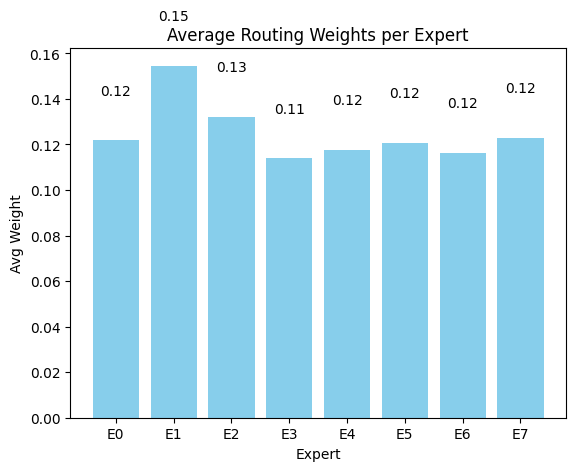

In [22]:
test_swiglu_and_moe()

#🎯 Positional Encodings

## Rotary Positional Embedding (RoPE)

In [23]:
import torch
import torch.nn as nn
import math

# RotaryPositionalEmbedding
class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=64, base=10000):
        super().__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)
        self.max_seq_len = max_seq_len
        self.register_buffer('cached_freqs', None)
        self.register_buffer('cached_seq_len', torch.tensor(0))

    def _update_cache(self, seq_len, device):
        if self.cached_freqs is None or seq_len > self.cached_seq_len:
            t = torch.arange(seq_len, device=device).type_as(self.inv_freq)
            freqs = torch.outer(t, self.inv_freq)
            freqs = torch.cat([freqs, freqs], dim=-1)
            self.cached_freqs = torch.stack([freqs.cos(), freqs.sin()], dim=0)
            self.cached_seq_len = torch.tensor(seq_len)

    def rotate_half(self, x):
        x1, x2 = x[..., :x.shape[-1]//2], x[..., x.shape[-1]//2:]
        return torch.cat([-x2, x1], dim=-1)

    def forward(self, q, k, seq_len=None, offset=0):
        if seq_len is None:
            seq_len = q.shape[-2]
        self._update_cache(seq_len+offset, q.device)
        cos, sin = self.cached_freqs
        cos = cos[offset:offset+seq_len]
        sin = sin[offset:offset+seq_len]
        q_rot = q * cos + self.rotate_half(q) * sin
        k_rot = k * cos + self.rotate_half(k) * sin
        return q_rot, k_rot

# ALiBi
class ALiBiPositionalBias(nn.Module):
    def __init__(self, num_heads, max_seq_len=64):
        super().__init__()
        slopes = self._get_slopes(num_heads)
        self.register_buffer('slopes', slopes.view(-1,1,1))
        bias = self._build_bias_matrix(max_seq_len)
        self.register_buffer('bias', bias)

    def _get_slopes(self, n):
        def get_slopes_power_of_2(n):
            start = 2**(-(2**-(math.log2(n)-3)))
            ratio = start
            return [start * ratio**i for i in range(n)]
        if math.log2(n).is_integer():
            slopes = get_slopes_power_of_2(n)
        else:
            p = 2**math.floor(math.log2(n))
            slopes = get_slopes_power_of_2(p)
            slopes += get_slopes_power_of_2(2*p)[:n-p]
        return torch.tensor(slopes)

    def _build_bias_matrix(self, L):
        ctx = torch.arange(L)[:,None]
        mem = torch.arange(L)[None,:]
        rel = mem - ctx
        return rel.unsqueeze(0)

    def forward(self, seq_len):
        b = self.bias[:,:seq_len,:seq_len]
        return self.slopes * b





In [24]:
import matplotlib.pyplot as plt

# # Test and visualization
def test_rotary_and_alibi():
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Create text examples
    tokenized_sentences, vocab = create_text_example()
    print("Original sentences:")
    sentences = [
        "the cat sat on the mat",
        "the dog ran fast",
        "the bird flew high",
        "the quick brown fox jumps"
    ]
    # for i, sentence in enumerate(sentences):
    #     print(f"  {i+1}. '{sentence}' -> {tokenized_sentences[i]}")

    # Pad sequences
    max_seq_len = 10
    padded_sequences = pad_sequences(tokenized_sentences, max_seq_len)
    input_ids = torch.tensor(padded_sequences)

    print(f"\nPadded input tensor shape: {input_ids.shape}")
    print("Padded sequences:")
    for i, seq in enumerate(padded_sequences):
        print(f"  Sequence {i+1}: {seq}")

    # Model configuration (using MHA config)
    d_model = 256
    num_heads = 8
    d_head = d_model//num_heads # dimension of each KV heads
    # num_kv_heads=2 # use 1 for MQA
    # d_kv = d_head * num_kv_heads
    # n_experts = 8
    vocab_size = len(vocab)
    batch_size, seq_length = input_ids.shape

    print(f"\nModel Configuration:")
    print(f"  d_model: {d_model}")
    print(f"  num_heads: {num_heads}")
    print(f"  dimension of each KV heads (d_head): {d_head}")
    # print(f"  number of KV heads (num_kv_heads): {num_kv_heads}")
    # print(f"  dimension of all K/V projections combined (d_kv): {d_kv}")
    # print(f"  number of experts (n_experts): {n_experts}")
    print(f"  vocab_size: {vocab_size}")
    print(f"  sequence_length: {seq_length}")

    # Embedding layer to convert IDs → embeddings
    # Create embedding layer
    embedding = nn.Embedding(vocab_size, d_head, padding_idx=0)

    # Convert tokens to embeddings
    x = embedding(input_ids)  # [batch_size, seq_length, d_head]
    print(f"\nEmbedding output shape [batch_size, seq_length, d_head]: {x.shape}")


    # B, T, C = 1, 32, 16  # [batch_size, seq_length, d_head]

    # Q,K same
    q, k = x, x

    # Rotary
    rotary = RotaryPositionalEmbedding(dim=d_head, max_seq_len=seq_length)
    q_rot, k_rot = rotary(q, k)
    # Visualize first dimension of cos/sin
    freqs = rotary.cached_freqs[0][:seq_length]
    plt.plot(freqs[:,0], label='cos')
    plt.plot(freqs[:,d_head//2], label='sin')
    plt.title('Rotary Cos/Sin Frequencies')
    plt.legend()
    plt.show()

    # ALiBi
    # heads = 4 # num_heads
    alibi = ALiBiPositionalBias(num_heads=num_heads, max_seq_len=seq_length)
    bias = alibi(seq_len=seq_length)
    # Plot bias for each head at query position 0
    for h in range(num_heads):
        plt.plot(bias[h,0].cpu().numpy(), label=f'head{h}')
    plt.title('ALiBi Bias at Query Pos 0')
    plt.xlabel('Key Position')
    plt.legend()
    plt.show()



In [25]:

# # Test and visualization
# def test_rotary_and_alibi():
#     torch.manual_seed(0)
#     B, T, C = 1, 32, 16
#     x = torch.randn(B, T, C)
#     # Q,K same
#     q, k = x, x

#     # Rotary
#     rotary = RotaryPositionalEmbedding(dim=C, max_seq_len=T)
#     q_rot, k_rot = rotary(q, k)
#     # Visualize first dimension of cos/sin
#     freqs = rotary.cached_freqs[0][:T]
#     plt.plot(freqs[:,0], label='cos')
#     plt.plot(freqs[:,C//2], label='sin')
#     plt.title('Rotary Cos/Sin Frequencies')
#     plt.legend()
#     plt.show()

#     # ALiBi
#     heads = 4
#     alibi = ALiBiPositionalBias(num_heads=heads, max_seq_len=T)
#     bias = alibi(seq_len=T)
#     # Plot bias for each head at query position 0
#     for h in range(heads):
#         plt.plot(bias[h,0].cpu().numpy(), label=f'head{h}')
#     plt.title('ALiBi Bias at Query Pos 0')
#     plt.xlabel('Key Position')
#     plt.legend()
#     plt.show()

Original sentences:

Padded input tensor shape: torch.Size([6, 10])
Padded sequences:
  Sequence 1: [1, 3, 4, 5, 6, 3, 7, 2, 0, 0]
  Sequence 2: [1, 3, 8, 9, 10, 18, 3, 19, 4, 2]
  Sequence 3: [1, 3, 11, 12, 13, 18, 3, 20, 23, 2]
  Sequence 4: [1, 3, 14, 15, 16, 17, 18, 3, 19, 8]
  Sequence 5: [1, 3, 21, 4, 5, 6, 3, 20, 7, 2]
  Sequence 6: [1, 3, 10, 8, 9, 18, 3, 21, 22, 2]

Model Configuration:
  d_model: 256
  num_heads: 8
  dimension of each KV heads (d_head): 32
  vocab_size: 26
  sequence_length: 10

Embedding output shape [batch_size, seq_length, d_head]: torch.Size([6, 10, 32])


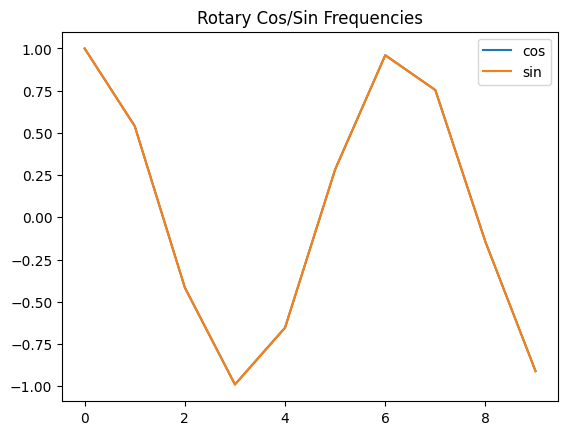

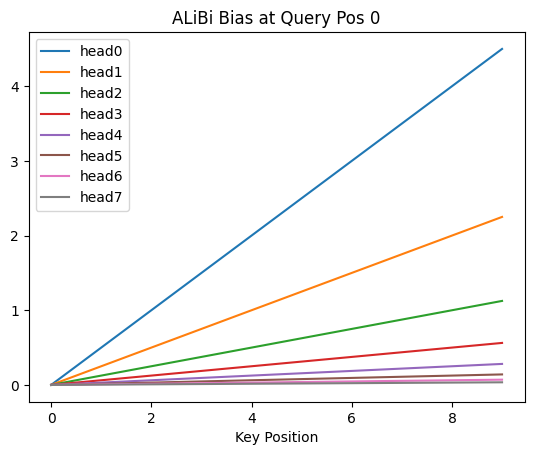

In [26]:
test_rotary_and_alibi()

# 📏 Advanced Normalization

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Root Mean Square Layer Normalization (RMSNorm)
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        rms = torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return x * rms * self.weight

# Layer Normalization with configurable axis
class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
        self.bias = nn.Parameter(torch.zeros(dim))

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True, unbiased=False)
        return (x - mean) / torch.sqrt(var + self.eps) * self.weight + self.bias

# Pre/Post-LayerNorm placement
class TransformerBlockPreNorm(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.ln1 = RMSNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.ln2 = RMSNorm(d_model)
        self.ff = SwiGLUFeedForward(d_model, d_ff, dropout)

    def forward(self, x, mask=None):
        # Pre-normalization
        x = x + self.attn(self.ln1(x), self.ln1(x), self.ln1(x), attn_mask=mask)[0]
        x = x + self.ff(self.ln2(x))
        return x

# Group Normalization for specific use cases
class GroupNorm1D(nn.Module):
    def __init__(self, num_groups, num_channels, eps=1e-5):
        super().__init__()
        self.num_groups = num_groups
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))

    def forward(self, x):
        # x: [B, T, C] -> [B, C, T] for GroupNorm -> [B, T, C]
        B, T, C = x.shape
        x = x.transpose(1, 2)  # [B, C, T]
        x = F.group_norm(x, self.num_groups, self.weight, self.bias, self.eps)
        return x.transpose(1, 2)  # [B, T, C]

In [28]:
import matplotlib.pyplot as plt

# Test & visualize

def test_normalizations_and_transformer():
    torch.manual_seed(0)
    B,T,C=3,100,256 # for similar effect change to 3,8,256
    x=torch.randn(B,T,C)

    # Test RMSNorm vs LayerNorm
    rms = RMSNorm(C)
    ln = LayerNorm(C)
    out_rms = rms(x)
    out_ln  = ln(x)
    # Compute per-timestep norm values
    norm_rms = out_rms.pow(2).mean(-1).sqrt().detach().numpy()
    norm_ln  = out_ln.pow(2).mean(-1).sqrt().detach().numpy()

    # Plot norm across sequence for first batch
    plt.figure(figsize=(6,3))
    plt.plot(norm_rms[0],label='RMSNorm output norm')
    plt.plot(norm_ln[0], label='LayerNorm output norm')
    plt.title('Output Norms per Timestep')
    plt.xlabel('Timestep')
    plt.ylabel('Norm')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Test GroupNorm1D
    gn = GroupNorm1D(num_groups=8,num_channels=C)
    out_gn = gn(x)
    norm_gn = out_gn.pow(2).mean(-1).sqrt().detach().numpy()
    plt.figure(figsize=(6,3))
    plt.plot(norm_gn[0],label='GroupNorm1D output norm',color='green')
    plt.title('GroupNorm1D Output Norm per Timestep')
    plt.xlabel('Timestep')
    plt.ylabel('Norm')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Test TransformerBlockPreNorm
    block = TransformerBlockPreNorm(d_model=C,num_heads=4,d_ff=128)
    mask = torch.zeros(T,T).float().masked_fill(torch.arange(T).unsqueeze(1)<torch.arange(T).unsqueeze(0), float('-inf'))
    out_block = block(x,mask=mask)
    print(f"TransformerBlockPreNorm output shape: {out_block.shape}")

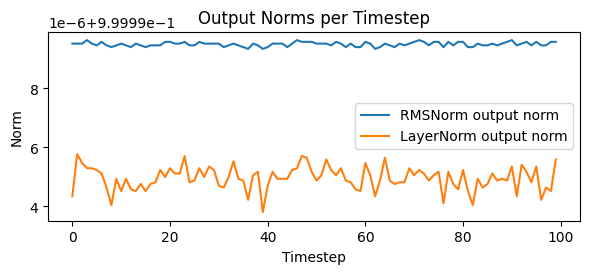

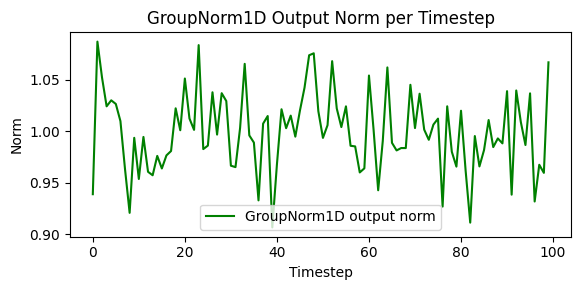

TransformerBlockPreNorm output shape: torch.Size([3, 100, 256])


In [29]:
test_normalizations_and_transformer()